# Offline classification model training

This notebook describe the CNN training for performing the gait representation (GEI) classification task. For replication purposes, is recommended to run this notebook on [Google Colab](https://colab.research.google.com/?hl=en) making use of the GPU runtime.

⚠️ When running this notebook, make sure you are using the same python version as the one used in the jetson nano device (3.6), where the model will be deployed. Also, make sure to install the same packages versions as the ones used in the jetson nano device. Otherwise, the model may not will be able to be accelerated and deployed in the Jetson Nano device.

In [1]:
!python3 --version

Python 3.6.13 :: Anaconda, Inc.


In [2]:
!pip install tensorflow-gpu==2.4.1

     |████████████████████████████████| 394.3 MB 49 kB/s  eta 0:00:01    |██████                          | 74.5 MB 105 kB/s eta 0:50:30     |███████▋                        | 94.4 MB 3.9 MB/s eta 0:01:17     |████████████████▎               | 200.3 MB 1.6 MB/s eta 0:01:59
     |████████████████████████████████| 5.9 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 289 kB 6

In [2]:
import tensorflow as tf

tensorflow_version = tf.__version__
print(tensorflow_version)

2.4.1


## Import libraries and pre-processing

In [1]:
from tensorflow import keras
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
datagenerator = ImageDataGenerator(rescale = 1/255.,
                                   width_shift_range=0.01, # horizontal shift
                                   horizontal_flip=True, # horizontal flip
                                   validation_split=0.2) 

In [4]:
training_data = '../../Datasets/OakGait16/representations_training_dataset'


img_height = 220
img_width = 220
batch_size = 4

train_ds = datagenerator.flow_from_directory(
    training_data,
    color_mode='grayscale',
    class_mode = "categorical",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset = "training"
)

val_ds = datagenerator.flow_from_directory(
    training_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode = "categorical",
    subset = "validation"
)

Found 3345 images belonging to 16 classes.
Found 828 images belonging to 16 classes.


In [5]:
classes = ['000','001','002','003','004','005','007','008','009','010','011','012','013','014','015','016']
print(classes)

['000', '001', '002', '003', '004', '005', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016']


In [6]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 4, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.axis("off")
  plt.tight_layout()
  plt.show()

(4, 220, 220, 1)


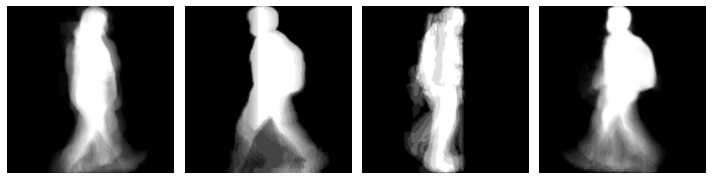

In [7]:
sample_training_images, _= next(iter(train_ds))
print(sample_training_images.shape)
plotImages(sample_training_images[:4])

## CNN model definition and training

In [8]:
model_cnn = keras.models.Sequential()

model_cnn.add(keras.layers.Conv2D(16, (3,3), padding='same'))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(32, (3,3), padding='same'))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same'))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer= regularizers.l2(1e-3)))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer= regularizers.l2(1e-3)))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))


model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(75, kernel_regularizer= regularizers.l2(1e-3)))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.Dropout(0.50))
model_cnn.add(keras.layers.Dense(len(classes), activation = "softmax"))

model_cnn.build((None, 220, 220, 1))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 16)      160       
_________________________________________________________________
activation (Activation)      (None, 220, 220, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 64)        1

In [9]:
keras.utils.plot_model(model_cnn, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get("val_accuracy") > 0.93:
      print("Achieved")
      self.model.stop_training = True

In [11]:
epochs = 25
optimizer = keras.optimizers.SGD(
    learning_rate=0.0001, momentum=0.9,  decay=1e-6, nesterov=True, name="SGD")

optimizer = keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

callback = TrainingCallback()


model_cnn.compile(optimizer=optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
training_samples = train_ds.n
val_samples = val_ds.n
history_cnn = model_cnn.fit(
    train_ds,
    steps_per_epoch=training_samples // batch_size,
    epochs = epochs,
    callbacks = [callback],
    validation_data=val_ds,
    validation_steps=val_samples // batch_size,
)

Epoch 1/25
836/836 [==============================] - 90s 106ms/step - loss: 3.0035 - accuracy: 0.0668 - val_loss: 2.8423 - val_accuracy: 0.1123
Epoch 2/25
836/836 [==============================] - 82s 98ms/step - loss: 2.7226 - accuracy: 0.1652 - val_loss: 2.0808 - val_accuracy: 0.3454
Epoch 3/25
836/836 [==============================] - 82s 98ms/step - loss: 2.0054 - accuracy: 0.4132 - val_loss: 1.5150 - val_accuracy: 0.5942
Epoch 4/25
836/836 [==============================] - 84s 101ms/step - loss: 1.4185 - accuracy: 0.6103 - val_loss: 1.1968 - val_accuracy: 0.6944
Epoch 5/25
836/836 [==============================] - 96s 114ms/step - loss: 1.1493 - accuracy: 0.7047 - val_loss: 1.0989 - val_accuracy: 0.7319
Epoch 6/25
836/836 [==============================] - 110s 131ms/step - loss: 0.9130 - accuracy: 0.7801 - val_loss: 0.9475 - val_accuracy: 0.7621
Epoch 7/25
836/836 [==============================] - 105s 126ms/step - loss: 0.7709 - accuracy: 0.8177 - val_loss: 1.0121 - val_ac

In [14]:
def visualizacion_resultados(history):
  nepochs = [i for i in range(25)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(nepochs, train_acc, "-", label =" Training accuracy")
  ax[0].plot(nepochs, val_acc, "-", label= "Validation accuracy")
  ax[0].set_title("Training & validation accuracy")
  ax[0].legend()
  ax[0].set_xlabel("nEpochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(nepochs, train_loss, "-", label =" Training Loss")
  ax[1].plot(nepochs, val_loss, "-", label= "Validation Loss")
  ax[1].set_title("Training & validation Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()

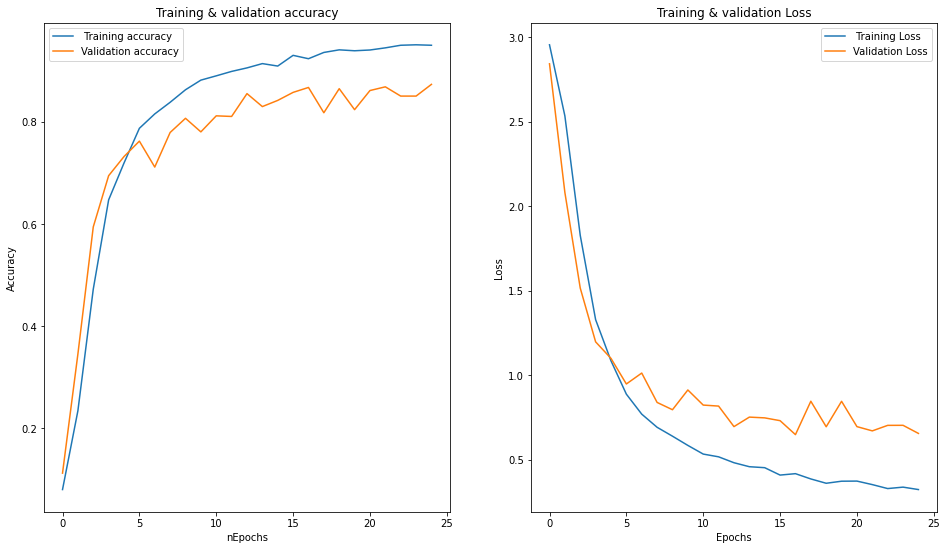

In [15]:
visualizacion_resultados(history_cnn)

              precision    recall  f1-score   support

           3       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



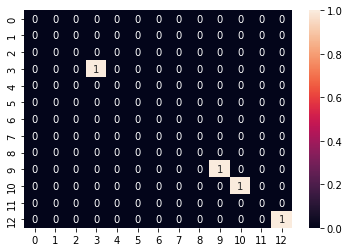

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
import seaborn as sns
import sklearn.metrics as metrics

test_batch = []
for data in next(val_ds):
  test_batch.append(data)

image_batch = test_batch[0]
label_batch = test_batch[1] 

predictions = np.argmax(model_cnn.predict(image_batch), axis=1)
label_batch = np.argmax(label_batch, axis=1)
cf_matrix = tf.math.confusion_matrix(label_batch, predictions)
sns.heatmap(cf_matrix, annot=True)
f1_score = metrics.classification_report(label_batch, predictions)
print(f1_score)

In [22]:
model_acc = round(history_cnn.history['accuracy'][-1], 4)
model_loss = round(history_cnn.history['loss'][-1], 4)
model_val_acc = round(history_cnn.history['val_accuracy'][-1], 4)
model_val_loss = round(history_cnn.history['val_loss'][-1], 4)

model_cnn_path = f"cnn_gait_recognition_acc_{model_acc}_loss_{model_loss}_val_acc_{model_val_acc}_loss_acc_{model_val_loss}"

In [23]:
model_cnn.save(model_cnn_path)

INFO:tensorflow:Assets written to: cnn_gait_recognition_acc_0.9497_loss_0.3227_val_acc_0.8732_loss_acc_0.6549/assets


INFO:tensorflow:Assets written to: cnn_gait_recognition_acc_0.9497_loss_0.3227_val_acc_0.8732_loss_acc_0.6549/assets


In [24]:
!zip -r "{model_cnn_path}.zip" "{model_cnn_path}"

  adding: cnn_gait_recognition_acc_0.9497_loss_0.3227_val_acc_0.8732_loss_acc_0.6549/ (stored 0%)
  adding: cnn_gait_recognition_acc_0.9497_loss_0.3227_val_acc_0.8732_loss_acc_0.6549/variables/ (stored 0%)
  adding: cnn_gait_recognition_acc_0.9497_loss_0.3227_val_acc_0.8732_loss_acc_0.6549/variables/variables.index (deflated 68%)
  adding: cnn_gait_recognition_acc_0.9497_loss_0.3227_val_acc_0.8732_loss_acc_0.6549/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: cnn_gait_recognition_acc_0.9497_loss_0.3227_val_acc_0.8732_loss_acc_0.6549/assets/ (stored 0%)
  adding: cnn_gait_recognition_acc_0.9497_loss_0.3227_val_acc_0.8732_loss_acc_0.6549/saved_model.pb (deflated 90%)
